# Introduction

Some adjacent images are difficult to stitch as they are different in birghtness and contrast due to the camera auto exposure control.

In this experiment, we test whether the histogram matching could improve the stitching performance.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt

from libpano import ImageCropper
from libpano import Config
from libpano import Stitcher
from libpano import FocalCalculator
from libpano import MetaData
from libpano import Preprocess

In [3]:
image_id = 'recent-04'
folder = '../images/' + image_id

In [4]:
meta = MetaData.MetaData(folder)
df = meta.grid_data

## Normal matching

In [5]:
row = 2
uris = df[df.row == row].uri.values.tolist()
pitches = df[df.row == row].pitch.values.tolist()
yaws = df[df.row == row].yaw.values.tolist()
roll = df[df.row == row].roll.values.tolist()

### find feature points

In [6]:
image_names = []
images = []
features = []
finder = cv.ORB_create()
for uri in uris:
    img_name = os.path.join(folder, uri)
    image_names.append(img_name)

    img = cv.imread(img_name)
    images.append(img)

    feature = cv.detail.computeImageFeatures2(finder, img) # cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    features.append(feature)

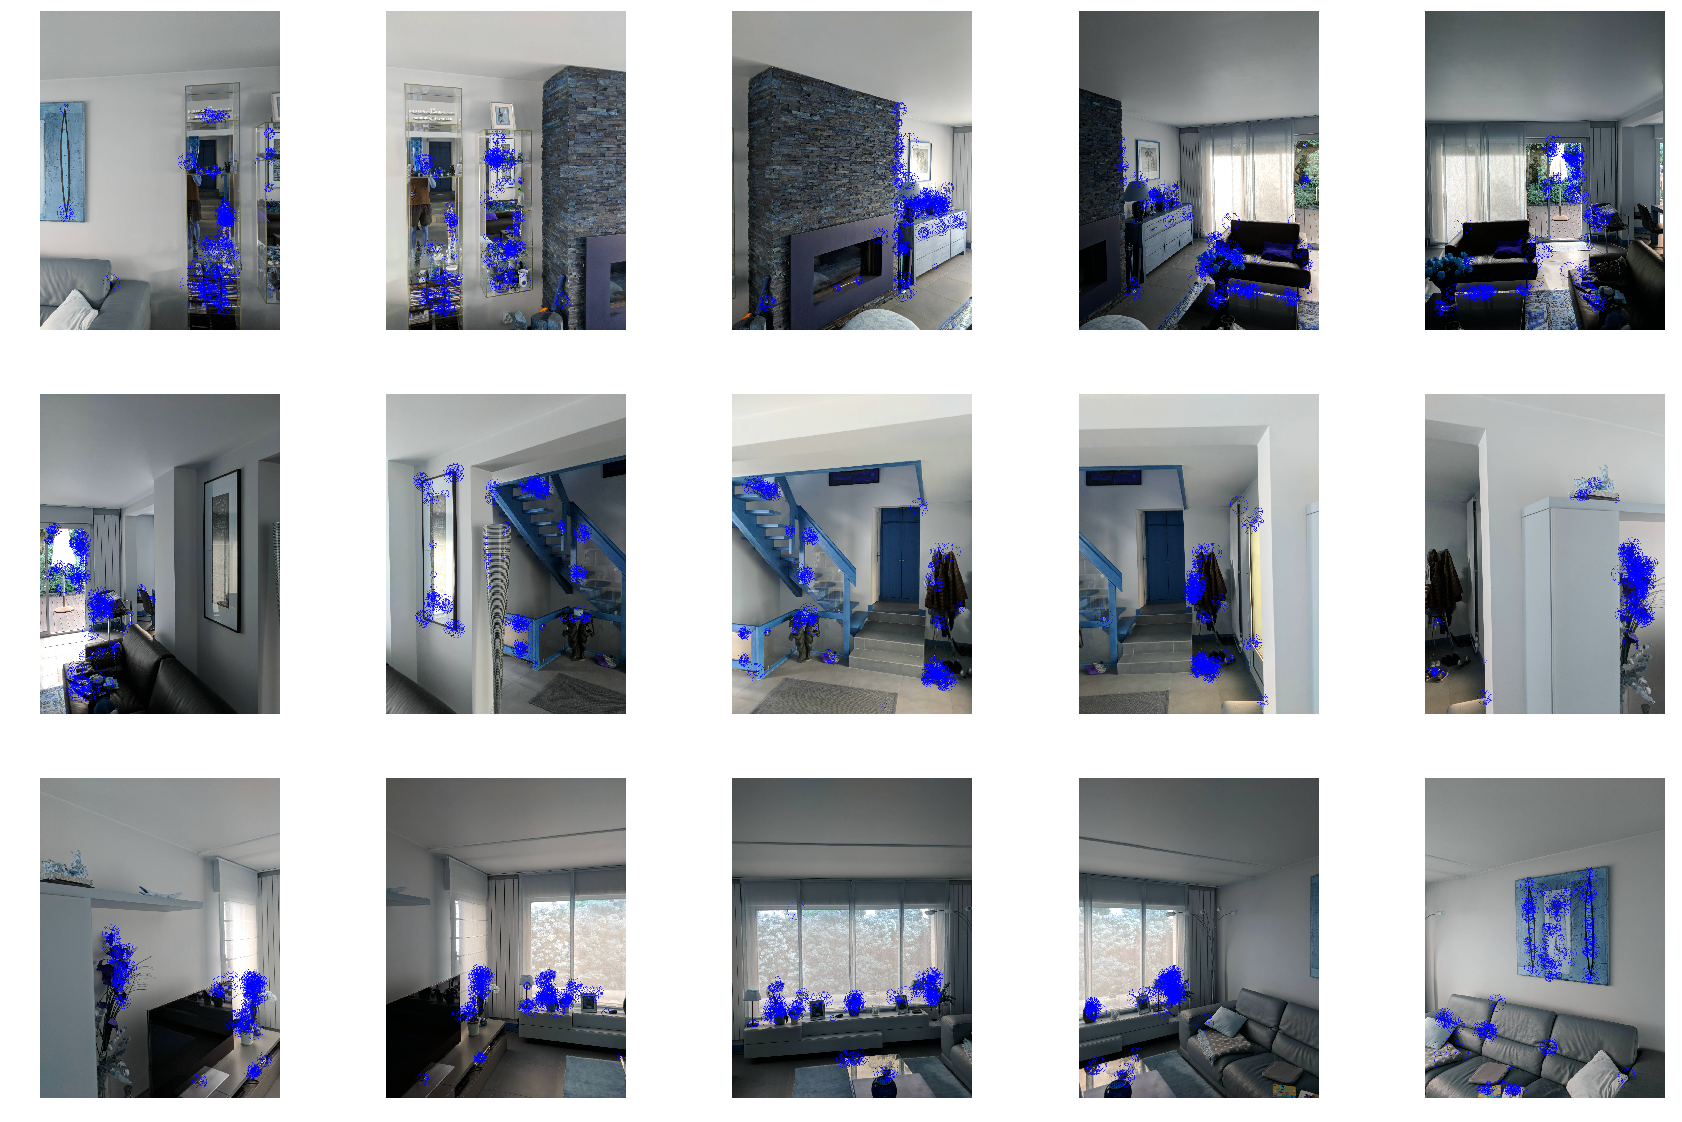

In [7]:
_, ax = plt.subplots(3, len(images)//3, figsize=(30, 20))
for idx, img in enumerate(images):
    img_with_keypoints = cv.drawKeypoints(img, features[idx].getKeypoints(), outImage=None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cur_ax = ax[idx//5][idx % 5]
    cur_ax.imshow(img_with_keypoints)
    cur_ax.axis('off')
plt.show()

In [8]:
matcher = cv.detail.BestOf2NearestMatcher_create(False, 0.3)
matches = matcher.apply2(features)

### Matching adjacent images

In [9]:
bad_match_indices = []

for idx, match_info in enumerate(matches):
    src_idx = match_info.src_img_idx
    dst_idx = match_info.dst_img_idx

    if src_idx + 1 != dst_idx:
        continue
        
    matches_list = match_info.getMatches()
    matches_mask = match_info.getInliers().ravel().tolist()
    draw_params = dict(matchesMask=matches_mask,
                       singlePointColor=None,
                       matchColor=(0, 255, 0),
                       flags=2)
    res = cv.drawMatches(images[src_idx], 
                         features[src_idx].getKeypoints(),
                         images[dst_idx], 
                         features[dst_idx].getKeypoints(),
                         matches_list, None, **draw_params)
    
    window_name = 'match-{} : {}-{} : match count = {}'.format(idx, src_idx, dst_idx, np.sum(matches_mask))
    cv.namedWindow(window_name, cv.WINDOW_NORMAL)
    cv.resizeWindow(window_name, 1200, 800)
    cv.imshow(window_name, res)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    if np.sum(matches_mask) < 10:
        bad_match_indices.append(idx)
        
    print(window_name)

match-1 : 0-1 : match count = 69
match-17 : 1-2 : match count = 5
match-33 : 2-3 : match count = 24
match-49 : 3-4 : match count = 21
match-65 : 4-5 : match count = 29
match-81 : 5-6 : match count = 5
match-97 : 6-7 : match count = 54
match-113 : 7-8 : match count = 108
match-129 : 8-9 : match count = 11
match-145 : 9-10 : match count = 23
match-161 : 10-11 : match count = 50
match-177 : 11-12 : match count = 72
match-193 : 12-13 : match count = 138
match-209 : 13-14 : match count = 4


There are 3 pairs which don't have enough matches. Let's see them.

In [10]:
features[0].getKeypoints()[0].pt

(1191.0, 1481.0)

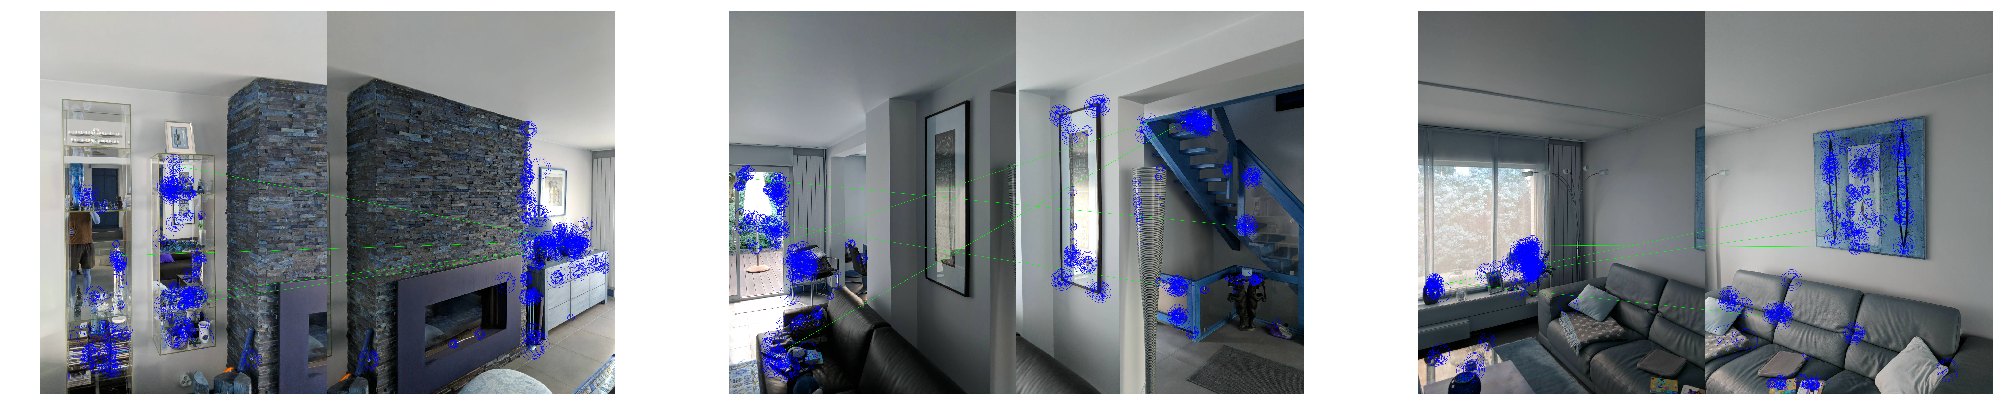

In [11]:
bad_match_imgs = []

for idx in bad_match_indices:
    match_info = matches[idx]

    src_idx = match_info.src_img_idx
    dst_idx = match_info.dst_img_idx

    matches_list = match_info.getMatches()
    matches_mask = match_info.getInliers().ravel().tolist()
    draw_params = dict(matchesMask=matches_mask,
                       singlePointColor=None,
                       matchColor=(0, 255, 0),
                       flags=2)
    
    res = cv.drawMatches(images[src_idx], 
                         features[src_idx].getKeypoints(),
                         images[dst_idx], 
                         features[dst_idx].getKeypoints(),
                         matches_list, None, **draw_params)
    
    # draw key points
    res = cv.drawKeypoints(res, features[src_idx].getKeypoints(), outImage=None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    right_keypoints = features[dst_idx].getKeypoints()
    width = images[src_idx].shape[1]
    for kp in right_keypoints:
        kp.pt = (kp.pt[0] + width, kp.pt[1])
    res = cv.drawKeypoints(res, right_keypoints, outImage=None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    bad_match_imgs.append(res)
    
bad_match_count = len(bad_match_imgs)    

_, ax = plt.subplots(1, bad_match_count, figsize=(35, 15))
for idx in range(bad_match_count):
    ax[idx].imshow(bad_match_imgs[idx])
    ax[idx].axis('off')
plt.show()

The fact that we can see from the mismatching pairs is that it extracts small amount of feature points in the overlapping area. Though there would be several reasons, but one of it is because the overlapping area of the image has low contrast and brightness.

As a way to overcome this problem, I suggest the histogram matching. 


In [12]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [13]:
uris

['img-r1-167.jpg',
 'img-r1-192.jpg',
 'img-r1-217.jpg',
 'img-r1-240.jpg',
 'img-r1-264.jpg',
 'img-r1-286.jpg',
 'img-r1-310.jpg',
 'img-r1-335.jpg',
 'img-r1-000.jpg',
 'img-r1-022.jpg',
 'img-r1-048.jpg',
 'img-r1-070.jpg',
 'img-r1-095.jpg',
 'img-r1-118.jpg',
 'img-r1-143.jpg']

In [14]:
for idx in range(len(images)-1):
    img1 = cv.imread(os.path.join(folder, uris[idx]))
    img2 = cv.imread(os.path.join(folder, uris[idx+1]))

    gray1 = cv.cvtColor(images[idx], cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(images[idx+1], cv.COLOR_BGR2GRAY)

    hist = hist_match(gray1, gray2).astype(np.uint8)
    
    stacked = np.hstack([gray1, gray2, hist])
    cv.namedWindow('hist_match', cv.WINDOW_NORMAL)
    cv.resizeWindow('hist_match', 1200, 300)
    cv.imshow('hist_match', stacked)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    feature1 = cv.detail.computeImageFeatures2(finder, hist)
    feature2 = cv.detail.computeImageFeatures2(finder, gray2)

    matches = matcher.apply2([feature1, feature2])
    real_match = None
    for match in matches:
        if match.src_img_idx == 0 and match.dst_img_idx == 1:
            real_match = match
            break

    matches_list = real_match.getMatches()
    matches_mask = real_match.getInliers().ravel().tolist()
    draw_params = dict(matchesMask=matches_mask,
                       singlePointColor=None,
                       matchColor=(0, 255, 0),
                       flags=2)
    res = cv.drawMatches(img1, 
                         feature1.getKeypoints(),
                         img2, 
                         feature2.getKeypoints(),
                         matches_list, None, **draw_params)
    cv.namedWindow('match', cv.WINDOW_NORMAL)
    cv.resizeWindow('match', 1200, 800)
    cv.imshow('match', res)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    


In [15]:
for idx in range(len(images)-1):
    img1 = cv.imread(os.path.join(folder, uris[idx]))
    img2 = cv.imread(os.path.join(folder, uris[idx+1]))

    gray1 = cv.cvtColor(images[idx], cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(images[idx+1], cv.COLOR_BGR2GRAY)

    hist = hist_match(gray1, gray2).astype(np.uint8)
    
    stacked = np.hstack([gray1, gray2, hist])
    cv.namedWindow('hist_match', cv.WINDOW_NORMAL)
    cv.resizeWindow('hist_match', 1200, 300)
    cv.imshow('hist_match', stacked)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    feature1 = cv.detail.computeImageFeatures2(finder, hist)
    feature2 = cv.detail.computeImageFeatures2(finder, gray2)

    matches = matcher.apply2([feature1, feature2])
    real_match = None
    for match in matches:
        if match.src_img_idx == 0 and match.dst_img_idx == 1:
            real_match = match
            break

    matches_list = real_match.getMatches()
    matches_mask = real_match.getInliers().ravel().tolist()
    draw_params = dict(matchesMask=matches_mask,
                       singlePointColor=None,
                       matchColor=(0, 255, 0),
                       flags=2)
    res = cv.drawMatches(img1, 
                         feature1.getKeypoints(),
                         img2, 
                         feature2.getKeypoints(),
                         matches_list, None, **draw_params)
    cv.namedWindow('match', cv.WINDOW_NORMAL)
    cv.resizeWindow('match', 1200, 800)
    cv.imshow('match', res)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    

# Conclusion

We experimented histogram matching method to improve matching performance. This method makes the histogram of image pairs and then perform feature extraction and matching. 

The result shows that **Histogram matching is not the solution of mismatching problem**.

We should research further to solve this problem. 

One candidate is to equalize the histogram of an image before the feature extraction. As we can see from the experiment, mismatching is due largely to the biased contrast and brightness of the image. 